In [1]:
import pandas as pd
import numpy as np

import xgboost as xgb
from xgboost import plot_importance
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

In [2]:
from google.colab import drive
drive.mount('/content/drive')

root_path = 'drive/MyDrive/NBA-predictions'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
df = pd.read_csv(root_path +'/data/2013_ppdf.csv')

In [4]:
def plot_confidence(y_test, y_preds, y_probs, bins=30, graph_range=(-1,0)):
  '''
  Plots predict_proba as a histogram.

  Note: The prediction probability is for HOME_WIN = 1, therefore the ideal graph would have most of its data centered around 40-60%.
    a 20% incorrect prediction for the HOME_WIN = 1 (when it should be 0) is the same magnitude of error as an 80% for predicting HOME_WIN = 0 (when it should be 1)

  '''
  import seaborn as sns
  import matplotlib.pyplot as plt
  sns.set(rc={'figure.figsize':(20, 8)})

  hist_data = pd.DataFrame()
  hist_data['TRUTH'] = y_test
  hist_data['PROBS'] = y_probs
  hist_data['PREDS'] = y_preds

  graph_col = list()
  for row in range(len(hist_data)):
    if hist_data.iloc[row].TRUTH == hist_data.iloc[row].PREDS: # the TRUTH matches the PREDICTION, append a POSITIVE PROBS
      graph_col.append(hist_data.iloc[row].PROBS)
    else:
      graph_col.append(hist_data.iloc[row].PROBS * (-1)) # the TRUTH does NOT match the PREDICTION, append a NEGATIVE PROBS

  hist_data['GRAPH'] = graph_col

  plt.hist([hist_data['GRAPH']], color=['blue'], bins=bins, range=graph_range)

  df_filter = hist_data.GRAPH < 0
  print('Mean confidence of error: ' + str(hist_data[df_filter]['GRAPH'].mean()))
  total_incorrect = hist_data[df_filter]['GRAPH'].count()

  df_filter = (hist_data.GRAPH < (-0.65)) | ((hist_data.GRAPH > (-0.35)) & (hist_data.GRAPH < (0)))
  print('Number of "strongly" incorrect (greater than 65% probability): ' + str(hist_data[df_filter]['GRAPH'].count()) + ' of ' + str(total_incorrect) + ' total incorrect.')
  
  return

## XGBoostRandomForestClassifier Model 1: 
# Historical Team Stats

This model uses the current Team's 2012 season average data to try and predict the winner of NBA games.

I experiment with different training methods:
1. Training and predicting on 2013
2. Training on 2013 & 2014, predicting on 2015
3. Training on ALL data, predicting on a smaller test set of ALL data
  - Note: The training data for all instances above is a SHUFFLED set (meaning the games are not necessarily in order, and potentially imbalanced with respect to each team) 

In [5]:
AWAY_TEAM_DICT = {
    'ATL' : 'AWAY_ATL',
    'BKN' : 'AWAY_BKN',
    'BOS' : 'AWAY_BOS', 
    'CHA' : 'AWAY_CHA', 
    'CHI' : 'AWAY_CHI', 
    'CLE' : 'AWAY_CLE', 
    'DAL' : 'AWAY_DAL', 
    'DEN' : 'AWAY_DEN', 
    'DET' : 'AWAY_DET', 
    'GSW' : 'AWAY_GSW', 
    'HOU' : 'AWAY_HOU', 
    'IND' : 'AWAY_IND', 
    'LAC' : 'AWAY_LAC', 
    'LAL' : 'AWAY_LAL', 
    'MEM' : 'AWAY_MEM', 
    'MIA' : 'AWAY_MIA', 
    'MIL' : 'AWAY_MIL', 
    'MIN' : 'AWAY_MIN', 
    'NOP' : 'AWAY_NOP', 
    'NYK' : 'AWAY_NYK', 
    'OKC' : 'AWAY_OKC', 
    'ORL' : 'AWAY_ORL', 
    'PHI' : 'AWAY_PHI', 
    'PHX' : 'AWAY_PHX', 
    'POR' : 'AWAY_POR', 
    'SAC' : 'AWAY_SAC', 
    'SAS' : 'AWAY_SAS', 
    'TOR' : 'AWAY_TOR', 
    'UTA' : 'AWAY_UTA', 
    'WAS' : 'AWAY_WAS',  
}
AWAY_TEAM = pd.get_dummies(df.AWAY_TEAM)
AWAY_TEAM = AWAY_TEAM.rename(columns=AWAY_TEAM_DICT)

HOME_TEAM = pd.get_dummies(df.HOME_TEAM)

model_df = df.copy()
model_df = model_df.drop(columns=['GAME_DATE', 'GAME_ID', 'MATCHUP', 'HOME_TEAM', 'AWAY_TEAM'])

#df_model = model_df.copy()

df_model = pd.concat((
    HOME_TEAM, 
    AWAY_TEAM,
    model_df
), axis=1)

In [6]:
df_model.head()

,ATL,BKN,BOS,CHA,CHI,CLE,DAL,DEN,DET,GSW,HOU,IND,LAC,LAL,MEM,MIA,MIL,MIN,NOP,NYK,OKC,ORL,PHI,PHX,POR,SAC,SAS,TOR,UTA,WAS,AWAY_ATL,AWAY_BKN,AWAY_BOS,AWAY_CHA,AWAY_CHI,AWAY_CLE,AWAY_DAL,AWAY_DEN,AWAY_DET,AWAY_GSW,AWAY_HOU,AWAY_IND,AWAY_LAC,AWAY_LAL,AWAY_MEM,AWAY_MIA,AWAY_MIL,AWAY_MIN,AWAY_NOP,AWAY_NYK,AWAY_OKC,AWAY_ORL,AWAY_PHI,AWAY_PHX,AWAY_POR,AWAY_SAC,AWAY_SAS,AWAY_TOR,AWAY_UTA,AWAY_WAS,HOME_PREV_SEAS_WIN_PERC,HOME_PREV_SEAS_AVG_PTS_PER_GAME,HOME_PREV_SEAS_FG_PERC,HOME_PREV_SEAS_THREE_PERC,HOME_PREV_SEAS_FREE_THROW_PERC,HOME_PREV_SEAS_PLUS_MINUS,AWAY_PREV_SEAS_WIN_PERC,AWAY_PREV_SEAS_AVG_PTS_PER_GAME,AWAY_PREV_SEAS_FG_PERC,AWAY_PREV_SEAS_THREE_PERC,AWAY_PREV_SEAS_FREE_THROW_PERC,AWAY_PREV_SEAS_PLUS_MINUS,HOME_WIN
0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0.605,94.7,43.6,34.7,74.6,4.0,0.244,94.1,44.8,32.9,75.5,-7.0,1
1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.549,102.2,45.8,35.5,69.2,1.2,0.683,101.1,47.8,35.8,71.1,6.5,1
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.805,102.9,49.6,39.6,75.4,7.9,0.549,93.2,43.7,35.3,77.3,0.3,1
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0.305,95.2,44.3,33.0,74.4,-6.5,0.402,97.5,44.8,35.3,77.6,-3.2,1
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.341,100.2,44.7,36.3,76.9,-4.9,0.695,106.1,47.8,34.3,70.1,5.1,1


In [7]:
X = df_model.drop(columns=['HOME_WIN'])
y = df_model['HOME_WIN']

In [8]:
mms = preprocessing.MinMaxScaler()
temp_df = X.copy()
for i in temp_df.columns[60:]:
  #print(i)
  X[i] = mms.fit_transform(temp_df[i].values.reshape(-1,1))

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [10]:
xg_clf = xgb.XGBRFClassifier(
    objective ='binary:logistic', 
    learning_rate = 0.3, 
    max_depth = 5, 
    reg_alpha = 0.1, 
    n_estimators = 750, 
    reg_lambda = 1, 
    random_state = 101,
    enable_categorical = True,
    #eval_set =[(X_train, y_train)], 
    #eval_metric='logloss',
    verbosity=1)

xg_clf.fit(X_train, y_train)

XGBRFClassifier(base_score=0.5, colsample_bylevel=1, colsample_bynode=0.8,
                colsample_bytree=1, enable_categorical=True, gamma=0,
                learning_rate=0.3, max_delta_step=0, max_depth=5,
                min_child_weight=1, missing=None, n_estimators=750, n_jobs=1,
                nthread=None, objective='binary:logistic', random_state=101,
                reg_alpha=0.1, reg_lambda=1, scale_pos_weight=1, seed=None,
                silent=None, subsample=0.8, verbosity=1)

In [11]:
preds = xg_clf.predict(X_test)
accuracy_score(y_test, preds, 
               #normalize=False
               )

0.6178861788617886

Mean confidence of error: -0.5318615535895029
Number of "strongly" incorrect (greater than 65% probability): 0 of 141 total incorrect.


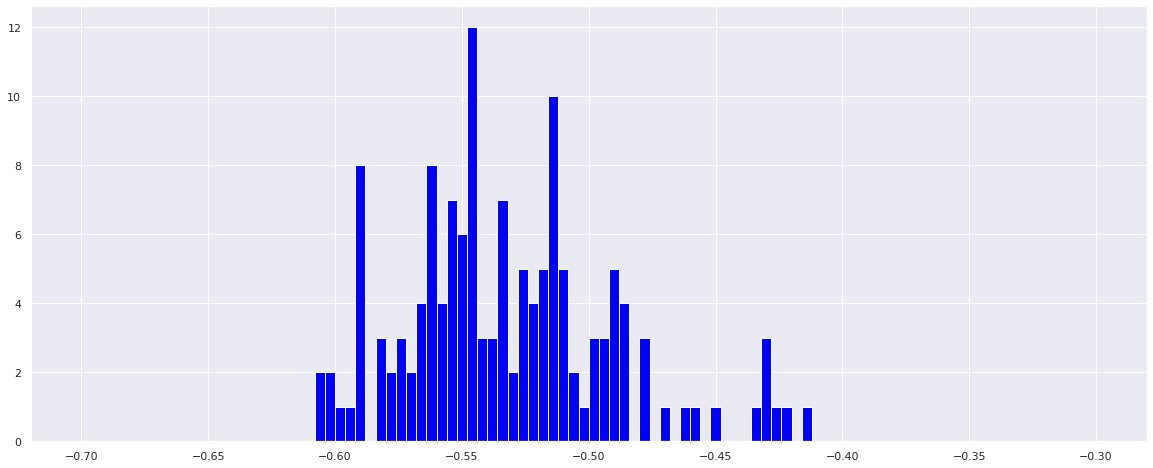

In [12]:
preds = xg_clf.predict(X_test)
probs = xg_clf.predict_proba(X_test)[:,1]
plot_confidence(y_test, preds, probs, bins=100, graph_range=(-0.7, -0.3))

## XGBoostRandomForestClassifier Model 2: 
# Rolling Average

This model using the Rolling Average statistical columns, in addition to the AWAY_TEAM and HOME_TEAM columns, to try and predict the winner.

I experiment with different training methods:
1. Training and predicting on 2013
2. Training on 2013 & 2014, predicting on 2015
3. Training on ALL data, predicting on a smaller test set of ALL data
  - **Note**: The training data for all instances above is a **SHUFFLED** set (meaning the games are not necessarily in order, and potentially imbalanced with respect to each team)

In [13]:


all_games = pd.read_csv(root_path +'/data/all_games_ppmadf.csv')
all_games.GAME_DATE = pd.to_datetime(all_games.GAME_DATE)

In [14]:
def get_season_by_year(year=2013, df=all_games):
  '''
  year = int
    NOTE: year = 2013, 2014, 2015 (due to dataset limitations)

  df = all_games by default

  Returns dataframe with games filtered by year.
  '''
  # Note: This function should be cleaned up to allow for more dynamic input
  # This is a quick implementation

  temp_df = df.copy()
  
  # pandas allows us to use strings to filter datetimes
  # we will use August 8th as the month and day to filter by season
  min_date = str(year) + '-08-08'
  max_date = str(year+1) + '-08-08'

  temp_df = temp_df.drop(temp_df[temp_df.GAME_DATE > max_date].index)
  temp_df = temp_df.drop(temp_df[temp_df.GAME_DATE < min_date].index)
  
  return temp_df

In [15]:
df_2013 = get_season_by_year(2013, df=all_games)
df_2014 = get_season_by_year(2014, df=all_games)
df_2015 = get_season_by_year(2015, df=all_games)

In [16]:
def create_training_data(df=all_games):
  '''
  Create a dataframe for training/testing using the df argument.

  Returns a DataFrame.
  '''

  AWAY_TEAM_DICT = {
      'ATL' : 'AWAY_ATL',
      'BKN' : 'AWAY_BKN',
      'BOS' : 'AWAY_BOS', 
      'CHA' : 'AWAY_CHA', 
      'CHI' : 'AWAY_CHI', 
      'CLE' : 'AWAY_CLE', 
      'DAL' : 'AWAY_DAL', 
      'DEN' : 'AWAY_DEN', 
      'DET' : 'AWAY_DET', 
      'GSW' : 'AWAY_GSW', 
      'HOU' : 'AWAY_HOU', 
      'IND' : 'AWAY_IND', 
      'LAC' : 'AWAY_LAC', 
      'LAL' : 'AWAY_LAL', 
      'MEM' : 'AWAY_MEM', 
      'MIA' : 'AWAY_MIA', 
      'MIL' : 'AWAY_MIL', 
      'MIN' : 'AWAY_MIN', 
      'NOP' : 'AWAY_NOP', 
      'NYK' : 'AWAY_NYK', 
      'OKC' : 'AWAY_OKC', 
      'ORL' : 'AWAY_ORL', 
      'PHI' : 'AWAY_PHI', 
      'PHX' : 'AWAY_PHX', 
      'POR' : 'AWAY_POR', 
      'SAC' : 'AWAY_SAC', 
      'SAS' : 'AWAY_SAS', 
      'TOR' : 'AWAY_TOR', 
      'UTA' : 'AWAY_UTA', 
      'WAS' : 'AWAY_WAS',  
  }
  AWAY_TEAM = pd.get_dummies(df.AWAY_TEAM)
  AWAY_TEAM = AWAY_TEAM.rename(columns=AWAY_TEAM_DICT)

  HOME_TEAM = pd.get_dummies(df.HOME_TEAM)

  df = df.drop(columns=[
                        'GAME_DATE',
                        'GAME_ID',
                        'MATCHUP',
                        'HOME_TEAM',
                        'AWAY_TEAM'
                        ])

  df_model = pd.concat((
      HOME_TEAM, 
      AWAY_TEAM,
      df
  ), axis=1)
  
  return df_model

In [17]:
dft_2013 = create_training_data(df_2013)
dft_2014 = create_training_data(df_2014)
dft_2015 = create_training_data(df_2015)
df_all = create_training_data(all_games)

X_13 = dft_2013.drop(columns=['HOME_WIN'])
y_13 = dft_2013['HOME_WIN']

X_14 = dft_2014.drop(columns=['HOME_WIN'])
y_14 = dft_2014['HOME_WIN']

X_15 = dft_2015.drop(columns=['HOME_WIN'])
y_15 = dft_2015['HOME_WIN']

X_all = df_all.drop(columns=['HOME_WIN'])
y_all = df_all['HOME_WIN']

mms = preprocessing.MinMaxScaler()

# 2013 data
temp_df = X_13.copy()
for i in temp_df.columns[60:]:
  #print(i)
  X_13[i] = mms.fit_transform(temp_df[i].values.reshape(-1,1))

# 2014 data
temp_df = X_14.copy()
for i in temp_df.columns[60:]:
  #print(i)
  X_14[i] = mms.fit_transform(temp_df[i].values.reshape(-1,1))

# 2015 data
temp_df = X_15.copy()
for i in temp_df.columns[60:]:
  #print(i)
  X_15[i] = mms.fit_transform(temp_df[i].values.reshape(-1,1))

# 2013-2015
temp_df = X_all.copy()
for i in temp_df.columns[60:]:
  #print(i)
  X_all[i] = mms.fit_transform(temp_df[i].values.reshape(-1,1))


# merge 2 years for training
X_1314 = X_13.append(X_14)
y_1314 = y_13.append(y_14)

test_size = 0.3
random_state = 101

X_train_13, X_test_13, y_train_13, y_test_13 = train_test_split(X_13, y_13, test_size=test_size, random_state=random_state)
X_train_14, X_test_14, y_train_14, y_test_14 = train_test_split(X_14, y_14, test_size=test_size, random_state=random_state)
X_train_15, X_test_15, y_train_15, y_test_15 = train_test_split(X_15, y_15, test_size=test_size, random_state=random_state)
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(X_all, y_all, test_size=test_size, random_state=random_state)

X_train_1314, X_test_1314, y_train_1314, y_test_1314 = train_test_split(X_1314, y_1314, test_size=test_size, random_state=random_state)


In [18]:
# 64.11% accurate on predicting 2015 data, after training on 2013/2014
# XGBRFClassifier(base_score=0.5, colsample_bylevel=1, colsample_bynode=0.8,
#                 colsample_bytree=0.6, enable_categorical=True, gamma=0.5,
#                 learning_rate=0.1, max_delta_step=0, max_depth=9,
#                 min_child_weight=1, missing=None, n_estimators=1000, n_jobs=4,
#                 nthread=None, objective='binary:logistic', random_state=101,
#                 reg_alpha=0.5, reg_lambda=1, return_train_score=True,
#                 scale_pos_weight=1, seed=None, silent=None, subsample=1,
#                 verbosity=1)


xgb_best = xgb.XGBRFClassifier(
    base_score=0.5, 
    colsample_bylevel=1, 
    colsample_bynode=0.8,
    colsample_bytree=0.6, 
    enable_categorical=True, 
    gamma=0.5,
    learning_rate=0.1, 
    max_delta_step=0, 
    max_depth=9,
    min_child_weight=1, 
    missing=None, 
    n_estimators=1000, 
    n_jobs=4,
    nthread=None, 
    objective='binary:logistic', 
    random_state=101,
    reg_alpha=0.5, 
    reg_lambda=1, 
    scale_pos_weight=1, 
    seed=None,
    silent=None, 
    subsample=1.0, 
    verbosity=1
    )

params = {
    'colsample_bytree': [0.6],
    'enable_categorical' : [True],
    'gamma': [0.5],
    'learning_rate' : [0.15],
    'max_depth': [9],
    'min_child_weight': [1],
    'n_estimators' : [1000],
    'n_jobs' : [4],
    'objective' : ['binary:logistic'],
    'random_state' : [101],
    'reg_alpha' : [0.5],
    'reg_lambda' : [1],
    'subsample': [1],
    'verbosity' :[1],
    'return_train_score': [True],
    }

In [19]:
xg_clf = xgb.XGBRFClassifier(verbosity=1)

In [20]:
# random_search = GridSearchCV(xg_clf, param_grid=params, scoring='accuracy', n_jobs=4, cv=5, verbose=3)
# random_search.fit(X_train_1314, y_train_1314)

In [21]:
# y_preds = random_search.predict(X_test_1314)
# accuracy_score(y_test_1314, y_preds)

In [22]:
# y_preds = random_search.predict(X_train_15)
# y_probs = random_search.predict_proba(X_train_15)[:,1]
# accuracy_score(y_train_15, y_preds)

In [23]:
# plot_confidence(y_train_15, y_preds, y_probs, bins=100, graph_range=(-0.55, -0.45))

In [24]:
# random_search.best_estimator_

# 64.11% accurate on predicting 2015 data, after training on 2013/2014
# XGBRFClassifier(base_score=0.5, colsample_bylevel=1, colsample_bynode=0.8,
#                 colsample_bytree=0.6, enable_categorical=True, gamma=0.5,
#                 learning_rate=0.1, max_delta_step=0, max_depth=9,
#                 min_child_weight=1, missing=None, n_estimators=1000, n_jobs=4,
#                 nthread=None, objective='binary:logistic', random_state=101,
#                 reg_alpha=0.5, reg_lambda=1, return_train_score=True,
#                 scale_pos_weight=1, seed=None, silent=None, subsample=1,
#                 verbosity=1)

In [25]:
xgb_best.fit(X_train_1314, y_train_1314)

XGBRFClassifier(base_score=0.5, colsample_bylevel=1, colsample_bynode=0.8,
                colsample_bytree=0.6, enable_categorical=True, gamma=0.5,
                learning_rate=0.1, max_delta_step=0, max_depth=9,
                min_child_weight=1, missing=None, n_estimators=1000, n_jobs=4,
                nthread=None, objective='binary:logistic', random_state=101,
                reg_alpha=0.5, reg_lambda=1, scale_pos_weight=1, seed=None,
                silent=None, subsample=1.0, verbosity=1)

In [26]:
preds = xgb_best.predict(X_test_1314)
accuracy_score(y_test_1314, preds)

0.6189151599443672

Mean confidence of error: -0.5024833647656615
Number of "strongly" incorrect (greater than 65% probability): 0 of 274 total incorrect.


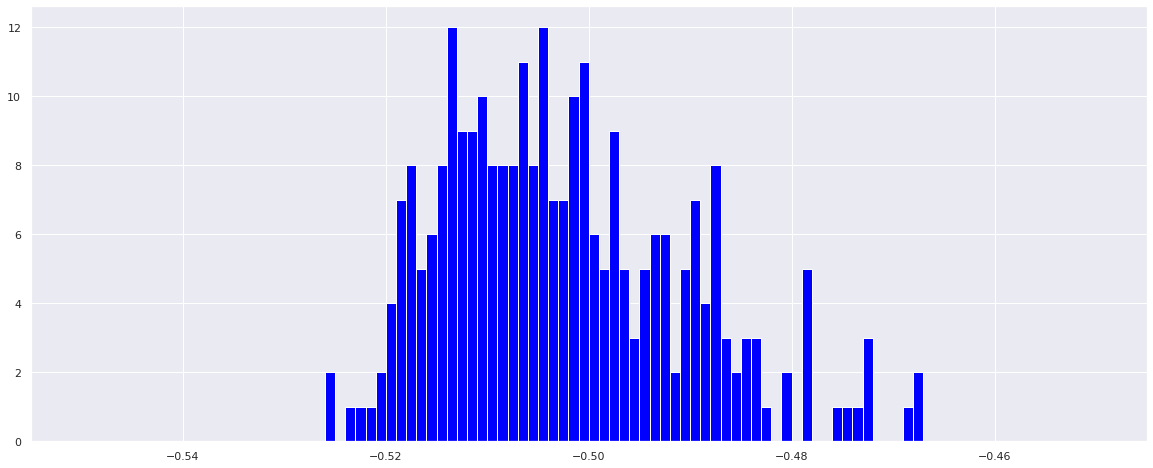

In [27]:
preds = xgb_best.predict(X_test_1314)
probs = xgb_best.predict_proba(X_test_1314)[:,1]
plot_confidence(y_test_1314, preds, probs, bins=100, graph_range=(-0.55, -0.45))

In [28]:
preds = xgb_best.predict(X_train_15)
probs = xgb_best.predict_proba(X_train_15)[:,1]
accuracy_score(y_train_15, preds)

0.6411149825783972

Mean confidence of error: -0.4999309669227662
Number of "strongly" incorrect (greater than 65% probability): 0 of 309 total incorrect.


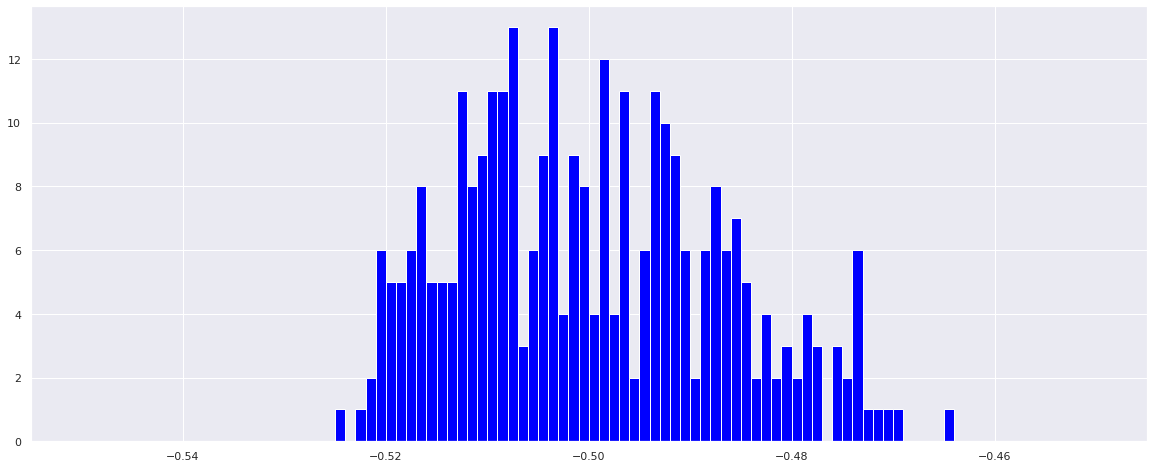

In [29]:
plot_confidence(y_train_15, preds, probs, bins=100, graph_range=(-0.55, -0.45))

In [30]:
xgb_best.save_model(root_path + '/data/xrgbfc_01.json')

In [31]:
# results = pd.DataFrame(random_search.cv_results_)
#results.columns

#results = results.sort_values(by=['rank_test_score'], ascending=False)
# results = results.sort_values(by=['mean_test_score'], ascending=False)

#results.head()
#print(results.iloc[0])
#print(results.iloc[0].params)
#results.to_csv(root_path+ '/data/xgb-random-grid-search-results-01.csv', index=False)

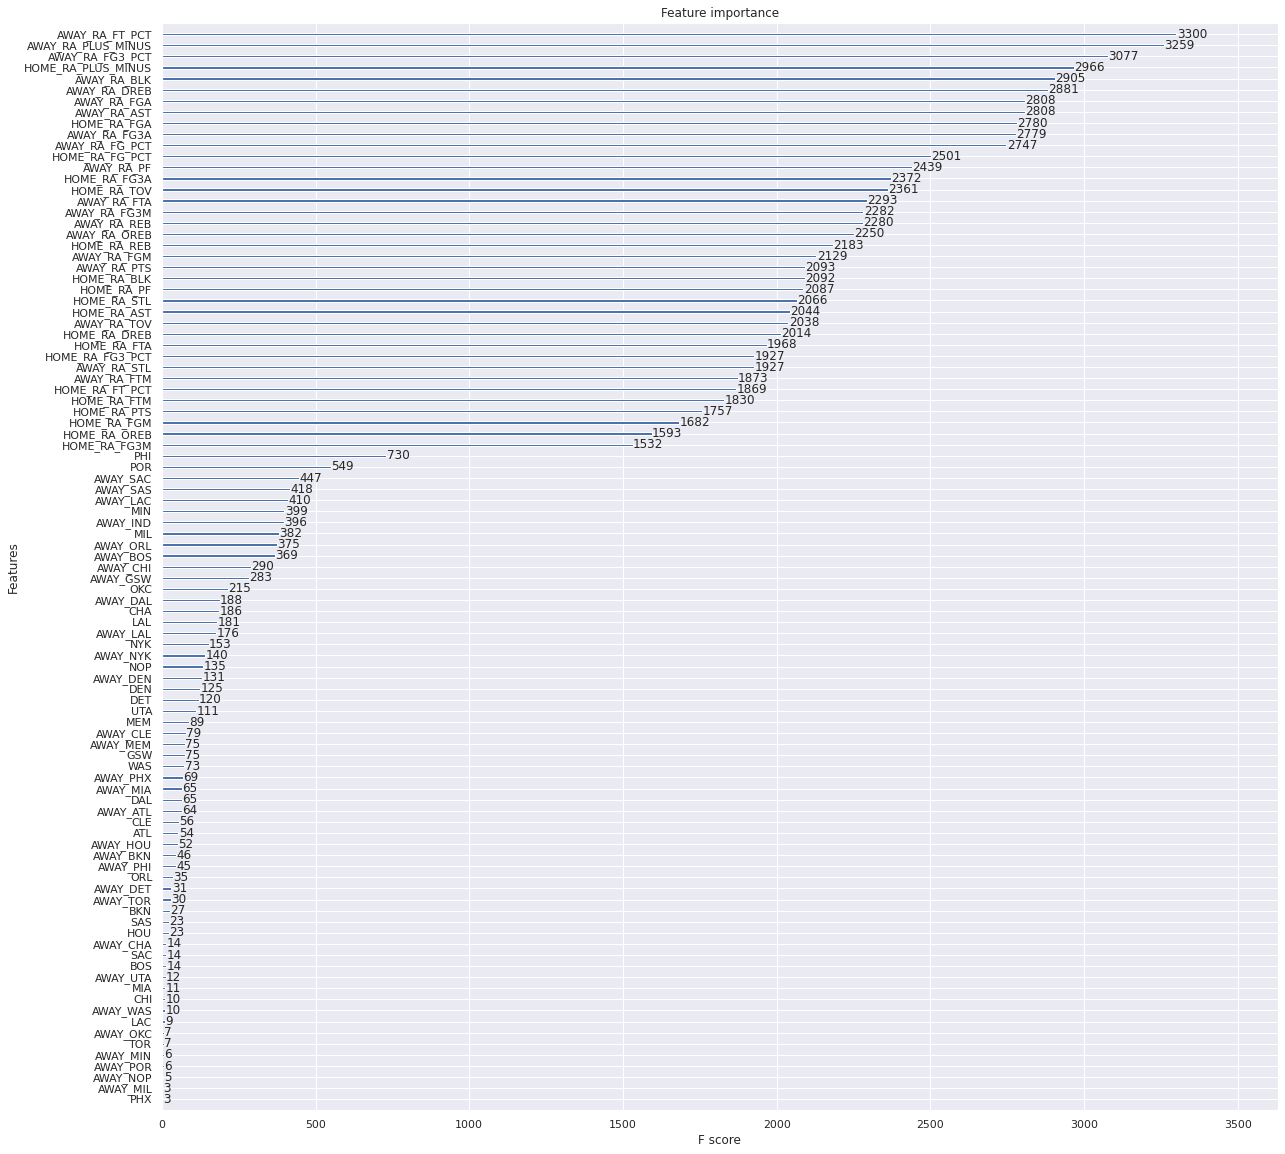

In [32]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(rc={'figure.figsize':(20, 20)})
plot_importance(xgb_best)
plt.show()

## XGBoostRandomForestClassifier Model 3: 
# 2013-2014 Training Data

In this section I address the possibility that the training data being scrambled may have been affecting the accuracy of the model (in either a good or bad way).

I have organized the training data to consist of all of the 2013-2014 matches. The test data consists of all of the 2015 season game matches.

I am still using the Rolling Average data.


In [33]:
train_data = pd.read_csv(root_path +'/data/train_data_ppmadf.csv')
test_data= pd.read_csv(root_path +'/data/test_data_ppmadf.csv')

X_train = train_data.drop(columns=['HOME_WIN'])
y_train = train_data['HOME_WIN']

X_test = test_data.drop(columns=['HOME_WIN'])
y_test = test_data['HOME_WIN']

In [92]:
xg_rfclf = xgb.XGBRFClassifier(
    objective ='binary:logistic', 
    random_state = 101,
    enable_categorical = True,
    # eval_set =[(X_train, y_train)], 
    # eval_metric='logloss',
    verbosity=1)

xg_clf = xgb.XGBClassifier()

In [43]:
# 64%
xgb_best = xgb.XGBRFClassifier(base_score=0.5, colsample_bylevel=1, colsample_bynode=0.8,
                colsample_bytree=0.6, enable_categorical=True, gamma=0.5,
                learning_rate=0.1, max_delta_step=0, max_depth=13,
                min_child_weight=1, missing=None, n_estimators=1000, n_jobs=4,
                nthread=None, objective='binary:logistic', random_state=101,
                reg_alpha=1, reg_lambda=2, return_train_score=True,
                scale_pos_weight=1, seed=None, silent=None, subsample=1,
                verbosity=1)

In [44]:
xgb_best.fit(X_train, y_train)

XGBRFClassifier(base_score=0.5, colsample_bylevel=1, colsample_bynode=0.8,
                colsample_bytree=0.6, enable_categorical=True, gamma=0.5,
                learning_rate=0.1, max_delta_step=0, max_depth=9,
                min_child_weight=1, missing=None, n_estimators=750, n_jobs=4,
                nthread=None, objective='binary:logistic', random_state=101,
                reg_alpha=0.1, reg_lambda=2, return_train_score=True,
                scale_pos_weight=1, seed=None, silent=None, subsample=1,
                verbosity=1)

In [45]:
easy_preds = xgb_best.predict(X_train)
print(accuracy_score(y_train, easy_preds))

0.8898163606010017


In [46]:
preds = xgb_best.predict(X_test)
probs = xgb_best.predict_proba(X_test)[:,1]

0.6227642276422765
Mean confidence of error: -0.5002275018727985
Number of "strongly" incorrect (greater than 65% probability): 0 of 464 total incorrect.


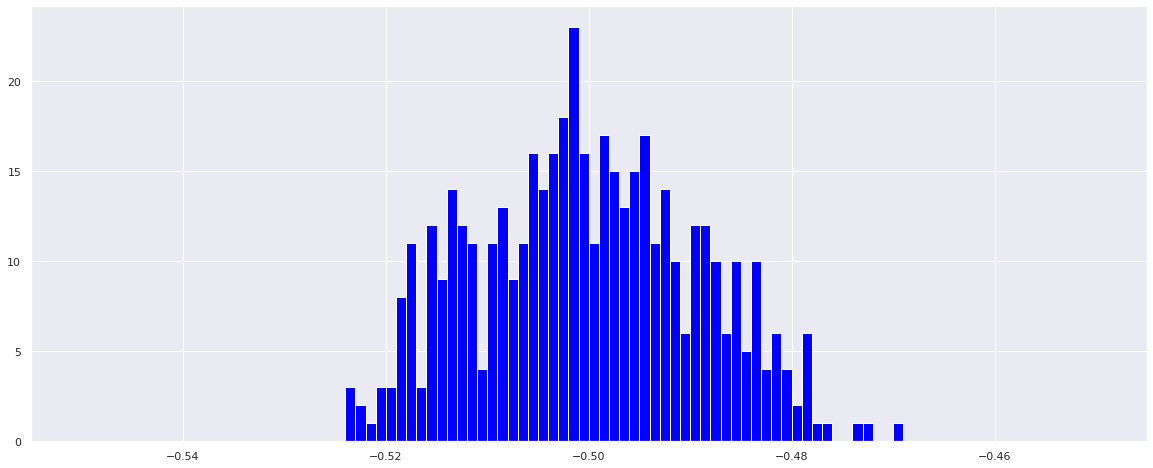

In [47]:
print(accuracy_score(y_test, preds))
plot_confidence(y_test, preds, probs, bins=100, graph_range=(-0.55, -0.45))

In [59]:
# 64%
xgb_best = xgb.XGBRFClassifier(base_score=0.5, colsample_bylevel=1, colsample_bynode=0.8,
                colsample_bytree=0.6, enable_categorical=True, gamma=0.5,
                learning_rate=0.1, max_delta_step=0, max_depth=13,
                min_child_weight=1, missing=None, n_estimators=1000, n_jobs=4,
                nthread=None, objective='binary:logistic', random_state=101,
                reg_alpha=1, reg_lambda=2, return_train_score=True,
                scale_pos_weight=1, seed=None, silent=None, subsample=1,
                verbosity=1)

In [97]:
params = {
    'colsample_bytree': [0.6, 0.7],        # best = 0.6
    'enable_categorical' : [True], 
    'gamma': [0.5, 1.0, 1.5],                   # best = 0.5
    'learning_rate' : [0.1, 0.15],          # best = 0.1
    'max_depth': [13, 14],                # best = 13
    'min_child_weight': [1],          # best = 1
    'n_estimators' : [1000],          # best = 1000
    'n_jobs' : [1], 
    'objective' : ['binary:logistic'],
    'random_state' : [101],
    'reg_alpha' : [1],        # best = 1
    'reg_lambda' : [3,5],         # best = 2
    'subsample': [1],
    'verbosity' :[1],
    'return_train_score': [True],
    }

In [98]:
random_search = GridSearchCV(xg_rfclf, param_grid=params, scoring='accuracy', n_jobs=1, cv=5, verbose=2)
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed: 62.0min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=XGBRFClassifier(base_score=0.5, colsample_bylevel=1,
                                       colsample_bynode=0.8, colsample_bytree=1,
                                       enable_categorical=True, gamma=0,
                                       learning_rate=1, max_delta_step=0,
                                       max_depth=3, min_child_weight=1,
                                       missing=None, n_estimators=100, n_jobs=1,
                                       nthread=None,
                                       objective='binary:logistic',
                                       random_state=101, reg_alpha=0,
                                       reg_lambda...
                         'enable_categorical': [True], 'gamma': [0.5, 1.0, 1.5],
                         'learning_rate': [0.1, 0.15], 'max_depth': [13, 14],
                         'min_child_weight': [1], 'n_estimators': [1000],
                         'n_jo

Test Accuracy:0.6333333333333333
Mean confidence of error: -0.5002916194911542
Number of "strongly" incorrect (greater than 65% probability): 0 of 451 total incorrect.


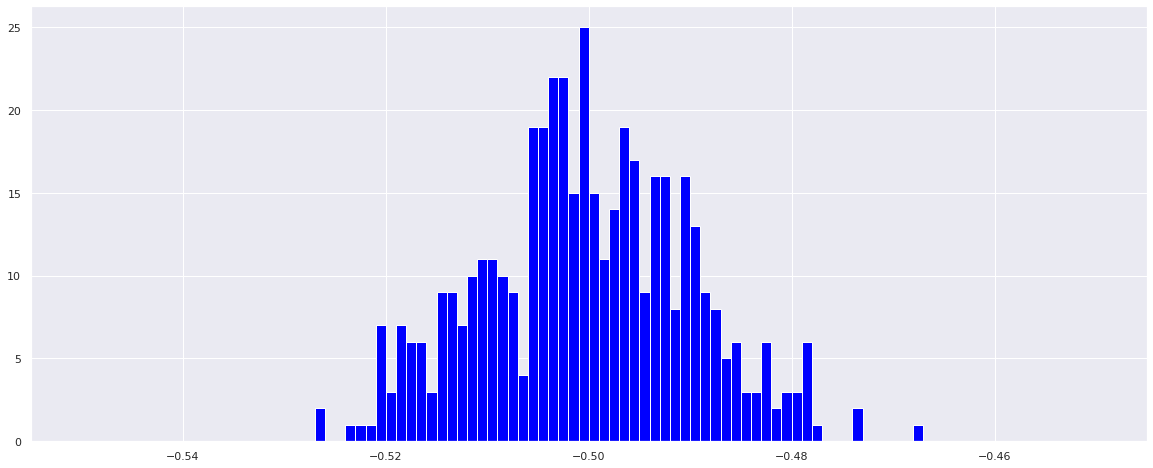

In [99]:
preds = random_search.predict(X_test)
probs = random_search.predict_proba(X_test)[:,1]
print('Test Accuracy:' + str(accuracy_score(y_test, preds)))
plot_confidence(y_test, preds, probs, bins=100, graph_range=(-0.55, -0.45))

In [100]:
random_search.best_estimator_

XGBRFClassifier(base_score=0.5, colsample_bylevel=1, colsample_bynode=0.8,
                colsample_bytree=0.6, enable_categorical=True, gamma=1.0,
                learning_rate=0.1, max_delta_step=0, max_depth=14,
                min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
                nthread=None, objective='binary:logistic', random_state=101,
                reg_alpha=1, reg_lambda=3, return_train_score=True,
                scale_pos_weight=1, seed=None, silent=None, subsample=1,
                verbosity=1)